
#### Mapping Stations to the NYC city map
  
As of this point, we should have a list of the most visited stations, and we want to narrow this list down so that we can focus our efforts on specific stations that will most prominently feature individuals who would be interested in a Women in Tech gala.



In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

Below, we take in csv files containing the locations of various colleges and universities, as well as subway station locations. They will be converted into dataframes where we have names, latitudes and longitudes.

In [2]:
college_df = pd.read_csv('https://data.cityofnewyork.us/api/views/8pnn-kkif/rows.csv')

In [3]:
college_df['the_geom'] = college_df['the_geom'].str.lstrip('POINT')
college_df['the_geom'] = college_df['the_geom'].str.strip()
college_df['the_geom'] = college_df['the_geom'].str.lstrip('(')
college_df['the_geom'] = college_df['the_geom'].str.rstrip(')')

new = college_df['the_geom'].str.split(' ', n = 1, expand=True)

college_df['Latitude'] = new[0]
college_df['Longitude'] = new[1]

college_df.drop(columns=['URL','BIN', 'BBL', 'the_geom', 'HOUSENUM','STREETNAME','CITY','ZIP'], inplace=True)
college_df.head()

,NAME,Latitude,Longitude
0,New School University / Parsons School Of Design,-73.99465215457163,40.73519616365903
1,New School University / The New School,-73.99706966379965,40.73546280987431
2,Metropolitan College,-74.00681944352681,40.723441859057495
3,School Of Nursing Of St. Vincents Catholic Med...,-73.79439300079635,40.73944287003665
4,Bramson Ort College,-73.84872054010768,40.721371886956774


In [4]:
station_df = pd.read_csv('https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv')

In [5]:
station_df['the_geom'] = station_df['the_geom'].str.lstrip('POINT')
station_df['the_geom'] = station_df['the_geom'].str.strip()
station_df['the_geom'] = station_df['the_geom'].str.lstrip('(')
station_df['the_geom'] = station_df['the_geom'].str.rstrip(')')

new = station_df['the_geom'].str.split(' ', n = 1, expand=True)

station_df['Latitude'] = new[0]
station_df['Longitude'] = new[1]

station_df.drop(columns=['URL','NOTES', 'OBJECTID', 'the_geom'], inplace=True)
station_df.head()

,NAME,LINE,Latitude,Longitude
0,Astor Pl,4-6-6 Express,-73.99106999861966,40.73005400028978
1,Canal St,4-6-6 Express,-74.00019299927328,40.71880300107709
2,50th St,1-2,-73.98384899986625,40.76172799961419
3,Bergen St,2-3-4,-73.97499915116808,40.68086213682956
4,Pennsylvania Ave,3-4,-73.89488591154061,40.66471445143568


In [6]:
# Need to convert to floats in order to work with them in geopandas
college_df['Latitude'] = college_df['Latitude'].astype(float)
college_df['Longitude'] = college_df['Longitude'].astype(float)

station_df['Latitude'] = station_df['Latitude'].astype(float)
station_df['Longitude'] = station_df['Longitude'].astype(float)

At this point, we have a dataframe containing colleges and their locations in Latitude and Longitude, and a similar dataframe for stations and their locations. Now we're going to pull in the top 25 stations that we determined previously and put together a dataframe with their locations.

In [10]:
top25_df = pd.read_csv('/home/danish/ds/metis/github/project01/project1/data/top_25_modified.csv')

top25_df.rename(columns = {'STATION': 'NAME'}, inplace=True)

In [11]:
top25_df['check'] = top25_df['NAME'].isin(station_df['NAME'])

top25_df = top25_df[top25_df.check == True]

top25_df.head()

top25_df = top25_df.merge(station_df, left_on='NAME', right_on='NAME')

top25_df['Latitude'] = top25_df['Latitude'].astype(float)
top25_df['Longitude'] = top25_df['Longitude'].astype(float)

In [12]:
# Remove duplicates
top25_df.drop_duplicates(subset='NAME', keep='last', inplace=True)

top25_df

,UNIT,NAME,NET,check,LINE,Latitude,Longitude
3,R033,Times Sq - 42nd St,164913.667,True,1-2-3,-73.987,40.755
7,R293,34th St - Penn Station,59587.333,True,A-C-E,-73.993,40.752
8,R461,Broadway - Lafayette St,150385.000,True,B-D-F-M,-73.996,40.725
13,R131,23rd St,117355.167,True,A-C-E,-73.998,40.746
16,R170,Union Sq - 14th St,92572.333,True,L,-73.991,40.735
21,R462,Canal St,91950.667,True,N-Q,-74.001,40.719
22,R029,World Trade Center,86199.500,True,E,-74.010,40.713
27,R014,Fulton St,79113.500,True,4-5,-74.010,40.710
28,R536,Jamaica Ctr - Parsons / Archer,74775.333,True,E-J-Z,-73.801,40.702
31,R057,Atlantic Av - Barclay's Center,72542.500,True,D-N-Q-R,-73.979,40.684


Now that we have latitude and longitude data for both sets, we are going to import a street map and utilize geopandas to plot it.

In [13]:
#Utilizing geopandas built-in NYC borough map as an underlay
streetmap = gpd.read_file(gpd.datasets.get_path('nybb'))
streetmap = streetmap.to_crs(epsg=4326)

We need to convert our latitudes and longitudes into usable points, and we need to specify a coordinate reference system (in this case the latitude/longitude projection system)

In [14]:
geometry_stations = [Point(xy) for xy in zip(top25_df['Latitude'], top25_df['Longitude'])]
geometry_colleges = [Point(xy) for xy in zip(college_df['Latitude'], college_df['Longitude'])]
crs = {'init': 'epsg:4326'}

In [15]:
college_geo_df = gpd.GeoDataFrame(college_df, crs=crs, geometry=geometry_colleges)
college_geo_df.head()

,NAME,Latitude,Longitude,geometry
0,New School University / Parsons School Of Design,-73.995,40.735,POINT (-73.99465215457163 40.73519616365903)
1,New School University / The New School,-73.997,40.735,POINT (-73.99706966379965 40.73546280987431)
2,Metropolitan College,-74.007,40.723,POINT (-74.00681944352681 40.72344185905749)
3,School Of Nursing Of St. Vincents Catholic Med...,-73.794,40.739,POINT (-73.79439300079635 40.73944287003665)
4,Bramson Ort College,-73.849,40.721,POINT (-73.84872054010768 40.72137188695677)


In [16]:
station_geo_df = gpd.GeoDataFrame(top25_df, crs=crs, geometry=geometry_stations)
station_geo_df.head()

,UNIT,NAME,NET,check,LINE,Latitude,Longitude,geometry
3,R033,Times Sq - 42nd St,164913.667,True,1-2-3,-73.987,40.755,POINT (-73.98749500051885 40.75528999995681)
7,R293,34th St - Penn Station,59587.333,True,A-C-E,-73.993,40.752,POINT (-73.99339099970578 40.75228700077589)
8,R461,Broadway - Lafayette St,150385.000,True,B-D-F-M,-73.996,40.725,POINT (-73.99620399876055 40.72529699873805)
13,R131,23rd St,117355.167,True,A-C-E,-73.998,40.746,POINT (-73.99804100117201 40.74590599939995)
16,R170,Union Sq - 14th St,92572.333,True,L,-73.991,40.735,POINT (-73.99066976901818 40.73476331217923)


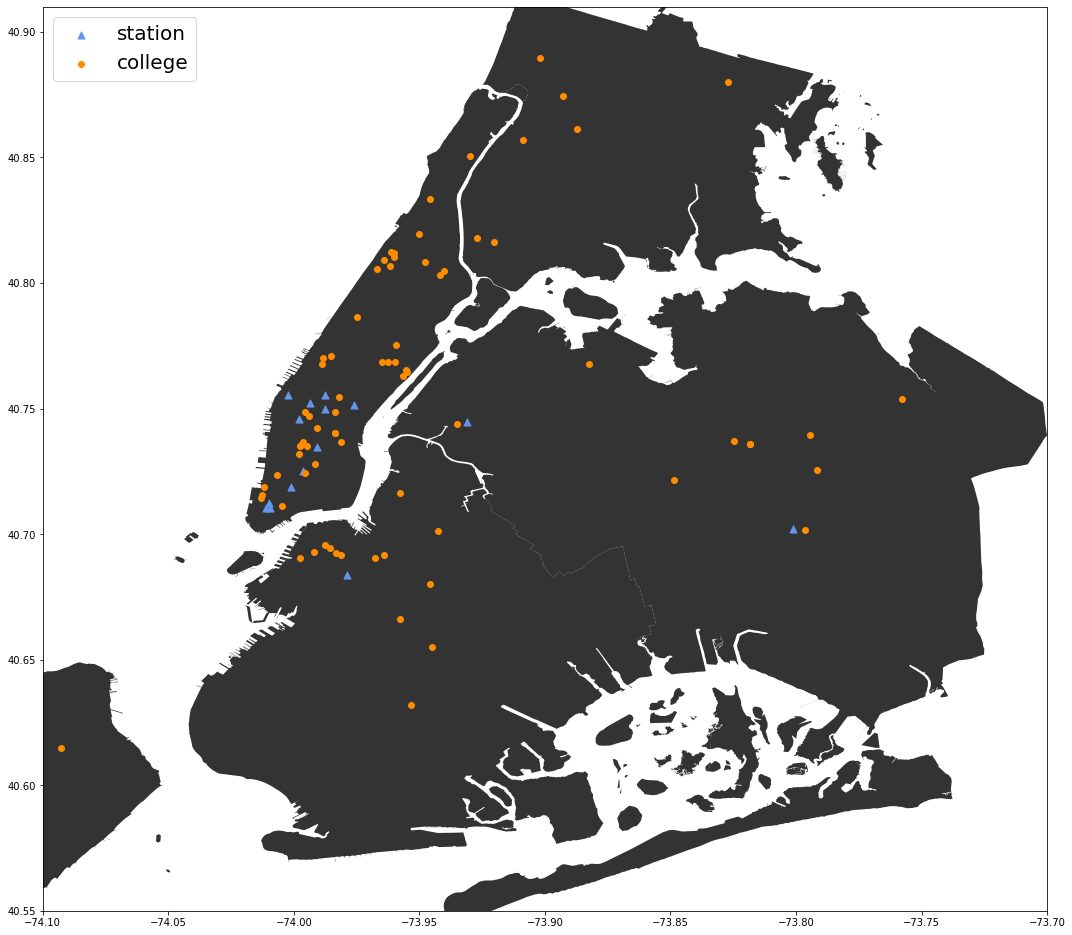

In [17]:
fig, ax = plt.pyplot.subplots(figsize=(18,18))
# minx, miny, maxx, maxy = geo_df.total_bounds

#Limiting borders in order to get a zoomed in image
ax.set_xlim(-74.1, -73.7)
ax.set_ylim(40.55, 40.91)

# ax = streetmap.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
streetmap.plot(ax=ax, alpha= 0.8, color='black');
station_geo_df.plot(ax=ax,color='#6495ED', markersize=50, marker='^', label='station');
college_geo_df.plot(ax=ax,color='#FF8C00', marker='o', label='college');
plt.pyplot.legend(loc='upper left', prop={'size': 20});
plt.pyplot.savefig('college station overlay.svg')

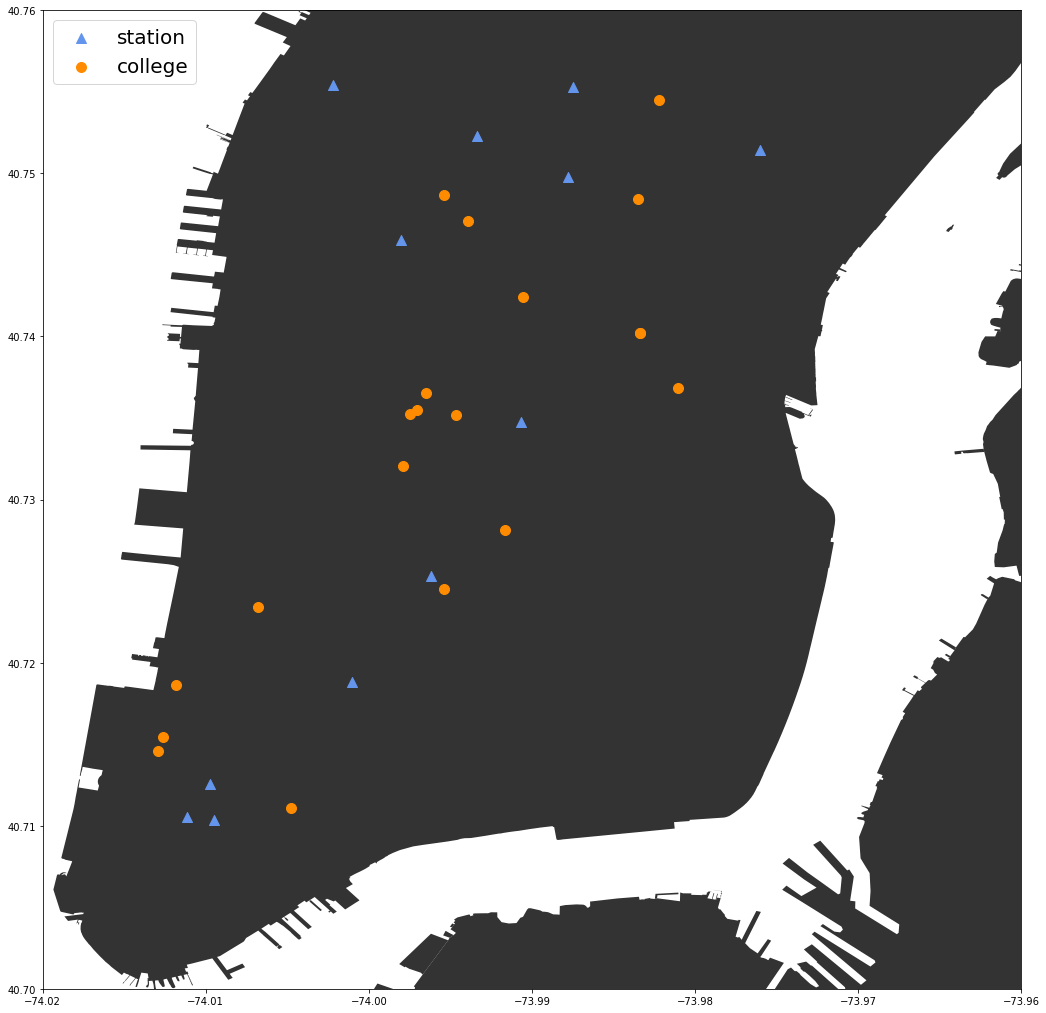

In [21]:
fig, ax = plt.pyplot.subplots(figsize=(18,18))
# minx, miny, maxx, maxy = geo_df.total_bounds

#Limiting borders in order to get a zoomed in image
ax.set_xlim(-74.02, -73.96)
ax.set_ylim(40.7, 40.76)

# ax = streetmap.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
streetmap.plot(ax=ax, alpha= 0.8, color='black');
station_geo_df.plot(ax=ax,color='#6495ED', markersize=100, marker='^', label='station');
college_geo_df.plot(ax=ax,color='#FF8C00', markersize=100, marker='o', label='college');
plt.pyplot.legend(loc='upper left', prop={'size': 20});
plt.pyplot.savefig('Manhattan overlay zoom.svg')